## Radar parameters at a point
In this notebook we will be extracting a bunch of radar and calculated disdrometer parameters at one point. The point of this is to compare real life disdrometer data with radar parameters calculated from the DSD.  

In [1]:
import xarray as xr
import pyart

from pyart_radar_tools import *


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


## Download data and store it locally

In [2]:
ID = 'KDIX'

t_start = '2016-02-25 03:00'
t_end = '2016-02-25 04:30'

paths = data_download(ID, t_start, t_end)

using cached file ...
./tmp/KDIX20160225_025507_V06.gz
using cached file ...
./tmp/KDIX20160225_030041_V06.gz
using cached file ...
./tmp/KDIX20160225_030614_V06.gz
using cached file ...
./tmp/KDIX20160225_031147_V06.gz
using cached file ...
./tmp/KDIX20160225_031715_V06.gz
using cached file ...
./tmp/KDIX20160225_032233_V06.gz
using cached file ...
./tmp/KDIX20160225_032748_V06.gz
using cached file ...
./tmp/KDIX20160225_033320_V06.gz
using cached file ...
./tmp/KDIX20160225_033853_V06.gz
using cached file ...
./tmp/KDIX20160225_034419_V06.gz
using cached file ...
./tmp/KDIX20160225_034938_V06.gz
using cached file ...
./tmp/KDIX20160225_035459_V06.gz
using cached file ...
./tmp/KDIX20160225_040032_V06.gz
using cached file ...
./tmp/KDIX20160225_040606_V06.gz
using cached file ...
./tmp/KDIX20160225_041123_V06.gz
using cached file ...
./tmp/KDIX20160225_041649_V06.gz
using cached file ...
./tmp/KDIX20160225_042214_V06.gz


## Define point

In [3]:
lat = 40.35
lon = -74.64

## Choose the fields that you want

In [4]:
fields = [
          'r_z',
          'kdp',
          'reflectivity',
          'differential_reflectivity',
          'D0',
          'NW',
          'MU',
         ]

## Run
Define a process_radar function that computes the fields that you specified above

In [5]:
def process_radar(path, run_QAQC=True,
                  min_dist_km=5, max_dist_km=250,
                  sw_vel=True, max_time_diff=30):
    radar = pyart.io.read(path)
    radar = extract_low_sweeps(radar)

    # run some QAQC:
    if run_QAQC:
        start_gate = get_gate_index(radar, dist_km=min_dist_km)
        end_gate = get_gate_index(radar, dist_km=max_dist_km)
        QAQC_mask = construct_QAQC_mask(radar, start_gate, end_gate,
                                        sw_vel=sw_vel,
                                        max_time_diff=max_time_diff)

    # get out just the sweeps with differential phase values
    radar = extract_field_sweeps(radar, field='differential_phase')
    
    # do computations
    radar = calculate_dsd_parameters(radar)
    radar = calculate_rain_nexrad(radar)
    radar = calculate_rain_kdp(radar)

    if run_QAQC:
        for field in fields:
            radar = interpolate_radially(radar, field, QAQC_mask,
                                         start_gate, end_gate)
    return radar

Run this process_data in a nested way so that we process the radar, get the sweep times, get the lat, lon, and elevation of the gate closest to the gate. 

In [6]:
%%time
radar0 = pyart.io.read(paths[0])
x_disp, y_disp = find_x_y_displacement(radar0, lon, lat)

sweep_times = []
sweep_stacks = []
for path in paths:
    print('processing', path)
    radar = process_radar(path, run_QAQC=False)
    for sweep in range(radar.nsweeps):
        # get time
        end_sweep_time = get_end_sweep_time(radar, sweep)
        sweep_times.append(end_sweep_time)
        
        # get data at point
        sweep_stack = retrieve_point(radar, sweep, fields, x_disp, y_disp)
        sweep_stacks.append(sweep_stack)

values = np.stack(sweep_stacks, axis=1)

cols = ['gate_lon', 'gate_lat', 'gate_altitude']
cols.extend(fields)

d = {'time': {'dims': ('time'), 'data': sweep_times}}
for i, name in enumerate(cols):
    d.update({name: {'dims': ('time'), 'data': values[i]}})
ds_radar = xr.Dataset.from_dict(d)
ds_radar.set_coords(['gate_altitude', 'gate_lat', 'gate_lon'], inplace=True)

('processing', './tmp/KDIX20160225_025507_V06.gz')


/home/jsignell/miniconda2/envs/radar-tools/lib/python2.7/site-packages/csu_radartools/csu_dsd.py:57: RuntimeWarning: overflow encountered in power
  return a * var**b
pyart_radar_tools.py:392: RuntimeWarning: divide by zero encountered in log10
  logNw = np.log10(Nw)
/home/jsignell/miniconda2/envs/radar-tools/lib/python2.7/site-packages/csu_radartools/common.py:74: RuntimeWarning: invalid value encountered in power
  return a * kdp**b
/home/jsignell/miniconda2/envs/radar-tools/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


('processing', './tmp/KDIX20160225_030041_V06.gz')
('processing', './tmp/KDIX20160225_030614_V06.gz')
('processing', './tmp/KDIX20160225_031147_V06.gz')
('processing', './tmp/KDIX20160225_031715_V06.gz')
('processing', './tmp/KDIX20160225_032233_V06.gz')
('processing', './tmp/KDIX20160225_032748_V06.gz')
('processing', './tmp/KDIX20160225_033320_V06.gz')
('processing', './tmp/KDIX20160225_033853_V06.gz')
('processing', './tmp/KDIX20160225_034419_V06.gz')
('processing', './tmp/KDIX20160225_034938_V06.gz')
('processing', './tmp/KDIX20160225_035459_V06.gz')
('processing', './tmp/KDIX20160225_040032_V06.gz')
('processing', './tmp/KDIX20160225_040606_V06.gz')
('processing', './tmp/KDIX20160225_041123_V06.gz')
('processing', './tmp/KDIX20160225_041649_V06.gz')
('processing', './tmp/KDIX20160225_042214_V06.gz')
CPU times: user 1min 15s, sys: 2.36 s, total: 1min 17s
Wall time: 1min 45s


In [7]:
ds_radar.to_netcdf('../PyDisdrometer/Notebooks/radar_output.nc')

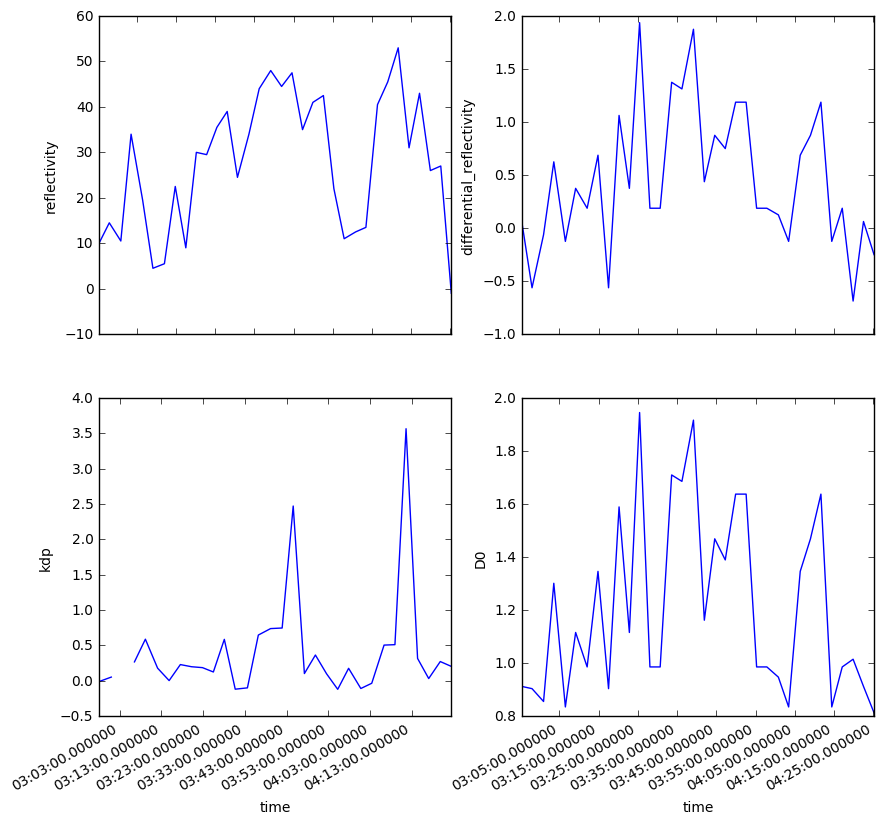

In [8]:
import matplotlib.pyplot as plt

fig, [[ax0, ax1],[ax2, ax3]] = plt.subplots(2, 2, figsize=(10,10))

ds_radar.reflectivity.plot(ax=ax0)
ds_radar.differential_reflectivity.plot(ax=ax1)
ds_radar.kdp.plot(ax=ax2)
ds_radar.D0.plot(ax=ax3)

plt.gcf().autofmt_xdate()

plt.show()